<a href="https://colab.research.google.com/github/sunny0103/DeepLearning_nlp_projects/blob/main/AIhub_translation/aihub_ko_eng_translate_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy evaluate sacrebleu

In [2]:
import pandas as pd
import numpy as np
import os
import random
from tqdm.notebook import tqdm
import warnings

import math

from sklearn.model_selection import train_test_split

from konlpy.tag import Hannanum

import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
from torch.utils.data import DataLoader
from torch import Tensor

import evaluate

warnings.filterwarnings('ignore')

In [3]:
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

seed_everything(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd "/content/drive/MyDrive/Data/aihub_kor_eng_translation"

/content/drive/MyDrive/Data/aihub_kor_eng_translation


## Load data and concat

AI hub 샘플 데이터에는 6개의 데이터 리스트가 있고 그중에서 문어체로 구성된 데이터로 프로젝트를 진행, 한국어 이름으로 된 데이터를 source 데이터 이름을 영어로 변경
-  '3_문어체_뉴스_190920.xlsx' -> 3_news.xlsx
-  '4_문어체_한국문화_190920.xlsx' -> 4_korean_culture.xlsx
-  '5_문어체_조례_190920.xlsx' -> 5_ordinance.xlsx
-  '6_문어체_지자체웹사이트_190920.xlsx' -> 6_local_govweb.xlsx

In [6]:
# ## concatenate lists of all the data ###
# files = ['3_news.xlsx', '4_korean_culture.xlsx', '5_ordinance.xlsx', '6_local_govweb.xlsx']
# df = pd.DataFrame()
# for idx, file in enumerate(files):
#   data = pd.read_excel('./'+file)
#   data['source'] = idx # data source 추가
#   data.columns = data.columns.str.lower() # 번역문 중에서 review를 사용
#   data= data[['원문','review','source']]
#   df = pd.concat([df, data], axis=0)
# total = pd.DataFrame(df)
# total.columns =['korean','english','source']
# display(total.head())
# print(total.shape)

# total.to_csv('./total.csv', index=False)

In [7]:
data = pd.read_csv('./total.csv')
data.head()

,korean,english,source
0,‘ZKZM-500 레이저 공격용 소총’으로 명명된 이 무기는 15㎜ 구경의 소총이며...,"Named the 'ZKZM-500 Laser Attack Rifle', the w...",0
1,“너희는 세상의 소금이니 소금이 만일 그 맛을 잃으면 무엇으로 짜게 하리요 후에는 ...,"""You are the salt of the earth. But if the sal...",0
2,“너희는 이 세대를 본받지 말고 오직 마음을 새롭게 함으로 변화를 받아 하나님의 선...,"""Do not conform to the pattern of this world, ...",0
3,“너희는 주께 받은바 기름 부음이 너희 안에 거하나니 아무도 너희를 가르칠 필요가 ...,"It is written as ""As for you, the anointing yo...",0
4,“너희는 택하신 족속이요 왕 같은 제사장들이요 거룩한 나라요….”(벧전 2:9) 따...,"""But you are a chosen people, a royal priestho...",0


## Making vocabulary

In [8]:
source_dataset = list(data['korean']) # source data
target_dataset = list(data['english']) # target_dataset

In [9]:
kor_tokenizer = get_tokenizer(Hannanum().morphs)
eng_tokenizer = get_tokenizer('spacy', language='en')

In [10]:
def vocab_iterator(strings, tokenizer):
  for _string in tqdm(strings):
    yield tokenizer(_string)

In [11]:
kor_vocab = build_vocab_from_iterator(vocab_iterator(source_dataset, kor_tokenizer), specials=['<PAD>', '<UNK>', '<BOS>', '<EOS>'], min_freq=5)
kor_vocab.set_default_index(kor_vocab['<UNK>'])

  0%|          | 0/44507 [00:00<?, ?it/s]

In [12]:
eng_vocab = build_vocab_from_iterator(vocab_iterator(target_dataset, eng_tokenizer), specials=['<PAD>', '<UNK>', '<BOS>', '<EOS>'], min_freq=5)
eng_vocab.set_default_index(eng_vocab['<UNK>'])

  0%|          | 0/44507 [00:00<?, ?it/s]

## Making train, valid,  test dataset

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(data.index.values,
                                                    data.source.values,
                                                    test_size=0.3,
                                                    stratify=data.source.values,
                                                    random_state = 42)

In [14]:
data['data_type'] =['not_set'] * data.shape[0]

data.loc[X_train, 'data_type'] = 'train'
data.loc[X_valid, 'data_type'] = 'valid'

In [15]:
X_valid, X_test, y_valid, y_test = train_test_split(data[data['data_type']=='valid'].index.values,
                                                    data[data['data_type']=='valid'].source.values,
                                                    test_size=0.5,
                                                    stratify=data[data['data_type']=='valid'].source.values,
                                                    random_state = 42)

In [16]:
data.loc[X_valid, 'data_type'] = 'valid'
data.loc[X_test, 'data_type'] = 'test'
data.head()

,korean,english,source,data_type
0,‘ZKZM-500 레이저 공격용 소총’으로 명명된 이 무기는 15㎜ 구경의 소총이며...,"Named the 'ZKZM-500 Laser Attack Rifle', the w...",0,train
1,“너희는 세상의 소금이니 소금이 만일 그 맛을 잃으면 무엇으로 짜게 하리요 후에는 ...,"""You are the salt of the earth. But if the sal...",0,valid
2,“너희는 이 세대를 본받지 말고 오직 마음을 새롭게 함으로 변화를 받아 하나님의 선...,"""Do not conform to the pattern of this world, ...",0,train
3,“너희는 주께 받은바 기름 부음이 너희 안에 거하나니 아무도 너희를 가르칠 필요가 ...,"It is written as ""As for you, the anointing yo...",0,train
4,“너희는 택하신 족속이요 왕 같은 제사장들이요 거룩한 나라요….”(벧전 2:9) 따...,"""But you are a chosen people, a royal priestho...",0,test


In [17]:
# split train valid test dataset
train_set = data[data.data_type == 'train']
valid_set = data[data.data_type == 'valid']
test_set = data[data.data_type == 'test']

In [18]:
# # sampling the set for cheching code
# train_set = train_set.sample(n=2000)
# valid_set = valid_set.sample(n=500)

In [19]:
def data_process(source_dataset, target_dataset):
  data = []
  for (raw_kor, raw_eng) in tqdm(zip(source_dataset, target_dataset)):
    kor_tensor_ = torch.tensor([kor_vocab[token] for token in kor_tokenizer(raw_kor)], dtype=torch.long)
    eng_tensor_ = torch.tensor([eng_vocab[token] for token in eng_tokenizer(raw_eng)], dtype=torch.long)

    data.append((kor_tensor_, eng_tensor_))

  return data

In [20]:
train_dataset = data_process(train_set['korean'], train_set['english'])
valid_dataset = data_process(valid_set['korean'], valid_set['english'])
test_dataset = data_process(test_set['korean'], test_set['english'])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [21]:
train_dataset[0][0]

tensor([    1,  5046,     1,     1,    22,  9623,    21,     8,     5,  4596,
           11,     1, 10542,     9,     1,     5,    54,    16,  5308,    11,
            1,     1, 10924,    11,     1,     7])

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )

In [23]:
print(kor_vocab['<BOS>'], kor_vocab['<EOS>'],kor_vocab['<UNK>'],kor_vocab['<PAD>'])
print(eng_vocab['<BOS>'], eng_vocab['<EOS>'],eng_vocab['<UNK>'],eng_vocab['<PAD>'])

2 3 1 0
2 3 1 0


In [24]:
PAD_IDX = kor_vocab['<PAD>']
UNK_IDX = kor_vocab['<UNK>']
BOS_IDX = kor_vocab['<BOS>']
EOS_IDX = kor_vocab['<EOS>']

In [25]:
def collate_fn(dataset):
  kor_batch, eng_batch = [], []
  kor_length, eng_length = [], []
  for (kor_item, eng_item) in dataset:
    kor_batch.append(kor_item)
    eng_batch.append(torch.cat([torch.tensor([BOS_IDX]), eng_item, torch.tensor([EOS_IDX])], dim=0))
    kor_length.append(len(kor_item))
    eng_length.append(len(eng_item)+1)

  kor_batch = pad_sequence(kor_batch, padding_value=PAD_IDX, batch_first=True)
  eng_batch = pad_sequence(eng_batch, padding_value=PAD_IDX, batch_first=True)
  kor_length = torch.from_numpy(np.array(kor_length))
  eng_length = torch.from_numpy(np.array(eng_length))
  return  kor_batch, kor_length, eng_batch, eng_length

In [26]:
BATCH_SIZE = 32

trainloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, collate_fn= collate_fn )
validloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn= collate_fn )
testloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn= collate_fn )

In [27]:
# kor_batch, eng_batch = [], []
# kor_length, eng_length = [], []
# for (kor_item, eng_item) in train_dataset[:5]:
#   kor_batch.append(kor_item)
#   eng_batch.append(torch.cat([torch.tensor([BOS_IDX]), eng_item, torch.tensor([EOS_IDX])], dim=0))
#   kor_length.append(len(kor_item))
#   eng_length.append(len(eng_item)+1)



# print(kor_batch, kor_length)
# print(kor_batch.size())


## Model

###Seq2Seq with Attention
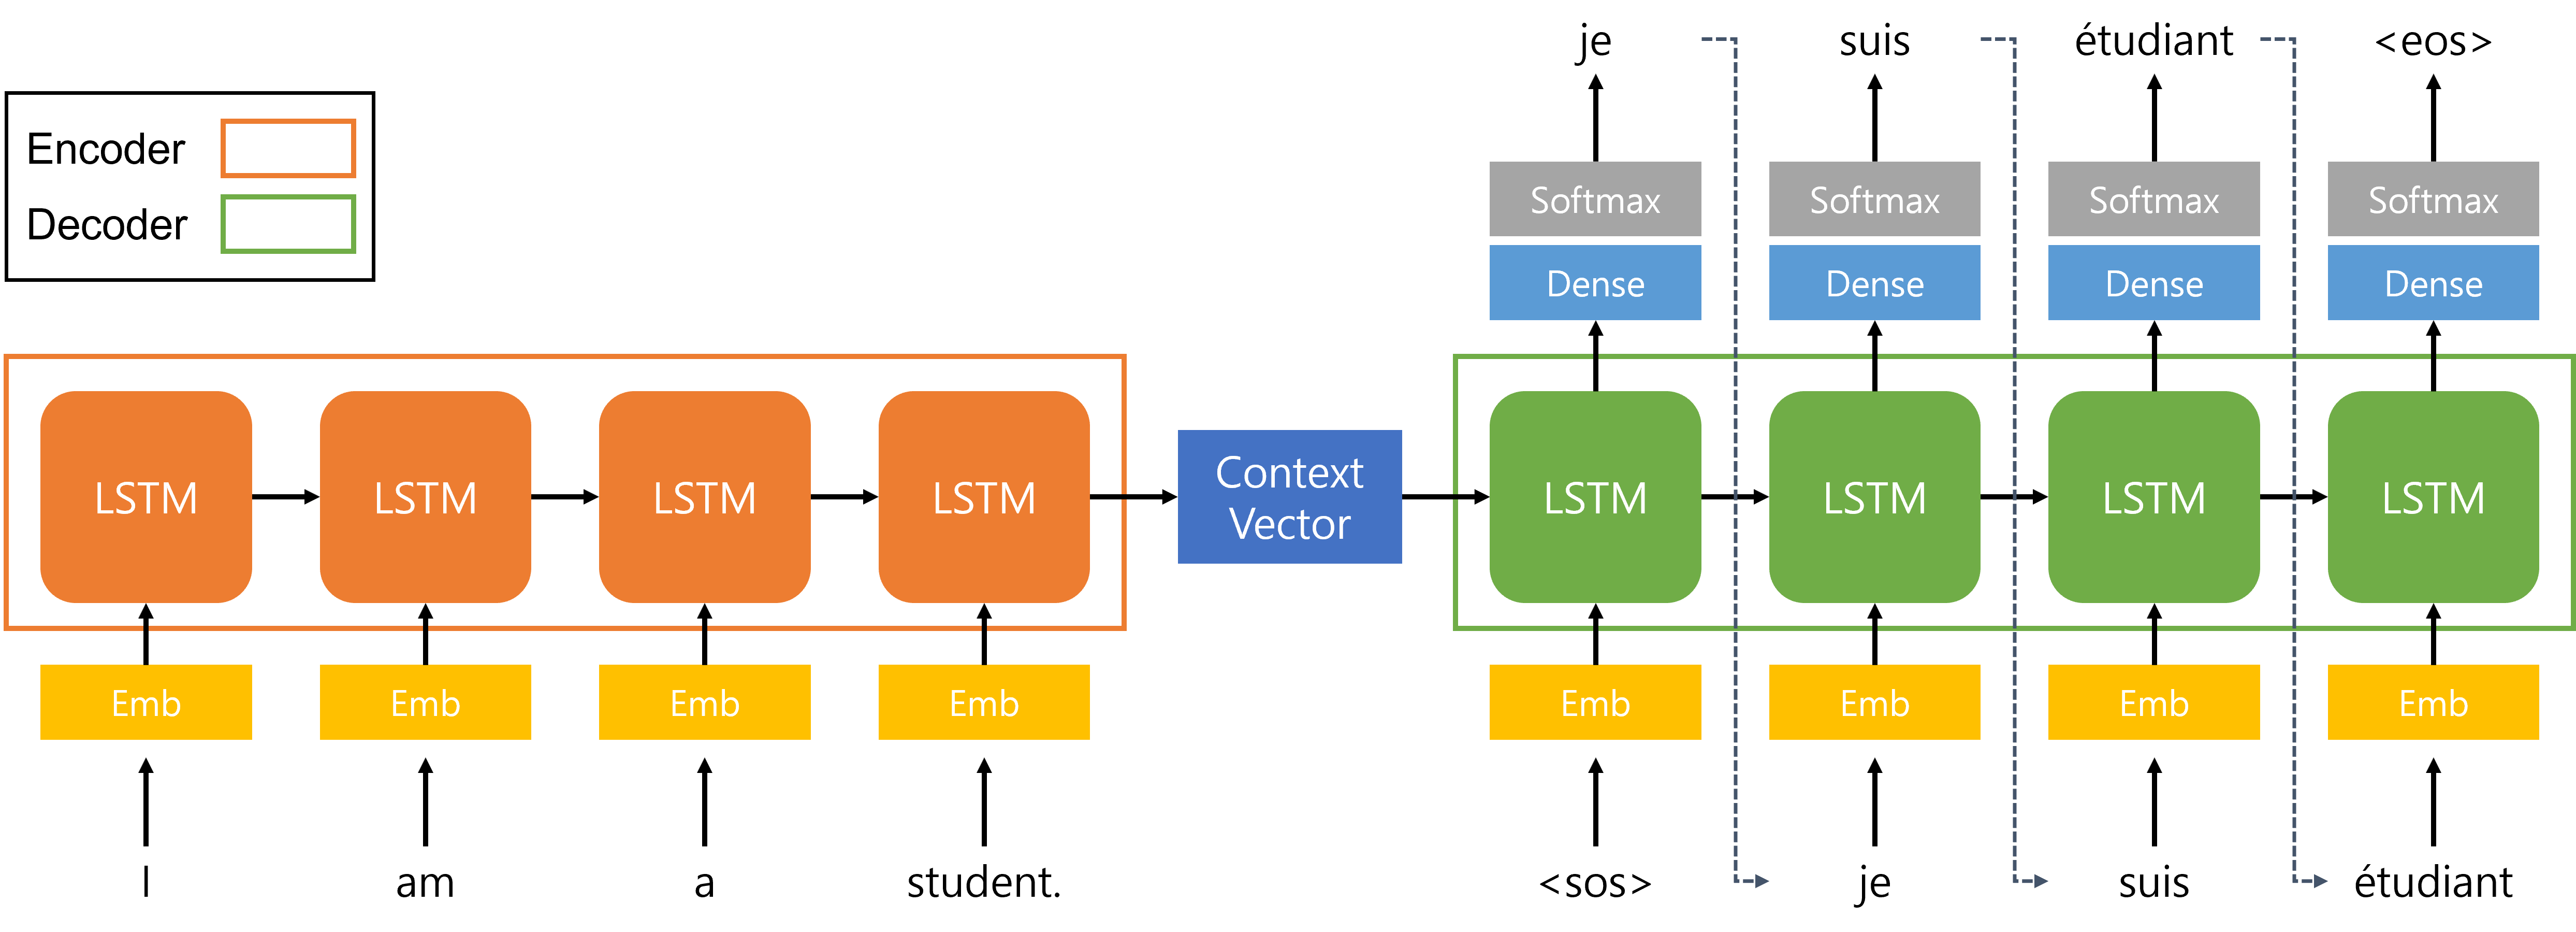

In [28]:
class Attention(nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()

    self.linear = nn.Linear(hidden_size, hidden_size, bias=False)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, h_src, h_t_tgt, mask=None):
    '''
    h_src = (batch_size, length, hidden_size)
    h_t_tgt = (batch_size, 1, hidden_size)
    '''
    query = self.linear(h_t_tgt) # (batch_size, 1, hidden_size)
    weight = torch.bmm(query, h_src.transpose(1, 2)) # (batch_size, 1, length)

    if mask is not None:
      weight.masked_fill_(mask.unsqueeze(1), -float('inf'))

    weight = self.softmax(weight)  # (batch_size, 1, length)

    context_vector = torch.bmm(weight, h_src) # (batch_size, 1, hidden_size)

    return context_vector

In [29]:
class Encoder(nn.Module):
  def __init__(self, word_vec_size, hidden_size, n_layers=4, dropout_p=0.2):
    super(Encoder, self).__init__()
    self.rnn = nn.LSTM(
        input_size=word_vec_size,
        hidden_size=int(hidden_size/2),
        num_layers=n_layers,
        dropout=dropout_p,
        bidirectional=True,
        batch_first=True
        )

  def forward(self, emb):
    # emb = (batch_size, length, word_vec_size)
    if isinstance(emb, tuple):
      x, lengths = emb
      x = pack_padded_sequence(x, lengths.tolist(), batch_first=True, enforce_sorted=False)
    else:
      x = emb

    y, h = self.rnn(x) # y = (batch_size, length, hidden_size), h[0] = (num_layer*2, batch, hidden_size)

    if isinstance(emb, tuple):
      y, _ = pad_packed_sequence(y, batch_first=True)

    return y, h


In [30]:
class Decoder(nn.Module):
  def __init__(self, word_vec_size, hidden_size, n_layers=4, dropout_p=.2):
    super(Decoder, self).__init__()

    self.rnn = nn.LSTM(
        input_size=word_vec_size + hidden_size,
        hidden_size=hidden_size,
        num_layers=n_layers,
        dropout=dropout_p,
        bidirectional=False,
        batch_first=True
        )

  def forward(self, emb_t, h_t_1_tilde, h_t_1):
    """
      emb_t = (batch_size, 1, word_vec_size)
      h_t_1_tilde = (batch_size, 1, hidden_size)=> previous lstm hidden from decoder
      h_t_1[0] = (n_layers, batch_size, hidden_size)
    """
    batch_size = emb_t.size(0)
    hidden_size = h_t_1[0].size(-1)

    if h_t_1_tilde is None:
      h_t_1_tilde = emb_t.new(batch_size, 1, hidden_size).zero_()

    x = torch.cat([emb_t, h_t_1_tilde], dim=-1)
    y, h = self.rnn(x, h_t_1)

    return y, h

In [31]:
class Generator(nn.Module):

  def __init__(self, hidden_size, output_size):
    super(Generator, self).__init__()

    self.output = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    # x = (batch_size, length, hidden_size)
    y = self.output(x) # y =(batcy_size, length, output_size)

    return y

In [32]:
class Seq2Seq(nn.Module):
  def __init__(self, input_size, word_vec_size, hidden_size, output_size, n_layers=4, dropout_p=0.2):
    super(Seq2Seq, self).__init__()

    self.input_size = input_size
    self.word_vec_size= word_vec_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    self.dropout_p = dropout_p

    self.emb_src = nn.Embedding(input_size, word_vec_size)
    self.emb_dec = nn.Embedding(output_size, word_vec_size)

    self.encoder = Encoder(word_vec_size,
                            hidden_size,
                            n_layers= n_layers,
                            dropout_p = dropout_p
                            )
    self.decoder = Decoder(word_vec_size,
                            hidden_size,
                            n_layers= n_layers,
                            dropout_p=dropout_p
                            )
    self.attn = Attention(hidden_size)
    self.concat = nn.Linear(hidden_size*2, hidden_size)
    self.tanh = nn.Tanh()
    self.generator = Generator(hidden_size, output_size)

  def generate_mask(self, x, length):
    '''
    filled with one where the lenth is shorter than maximum length
    '''
    mask = []

    max_length = max(length)
    for l in length:
      if max_length - l > 0:
        mask += [torch.cat([x.new_ones(1, l).zero_(),
                            x.new_ones(1, (max_length-l))
                            ], dim=-1)]
      else:
        mask += [x.new_ones(1, l).zero_()]

    mask = torch.cat(mask, dim=0).bool()

    return mask

  def merge_encoder_hiddens(self, encoder_hiddens):
    """
    convert encoder hidden size (n_layers *2, batch, hidden/2) -> (n_layers, batch, hidden)
    """
    h_0_tgt, c_0_tgt = encoder_hiddens
    batch_size = h_0_tgt.size(1)

    h_0_tgt = h_0_tgt.transpose(0, 1).contiguous().view(batch_size,
                                                        -1,
                                                        self.hidden_size
                                                        ).transpose(0, 1).contiguous()
    c_0_tgt = c_0_tgt.transpose(0, 1).contiguous().view(batch_size,
                                                        -1,
                                                        self.hidden_size
                                                        ).transpose(0, 1).contiguous()
    return h_0_tgt, c_0_tgt

  def forward(self, src, tgt):
    batch_size = tgt.size(0)

    mask = None
    x_length = None

    if isinstance(src, tuple):
      x, x_length = src
      mask = self.generate_mask(x, x_length)
    else:
      x = src

    if isinstance(tgt, tuple):
      tgt = tgt[0]

    emb_src = self.emb_src(x) # emb_src = (batch_size, length, word_vec)

    h_src, h_0_tgt = self.encoder((emb_src, x_length))
    h_0_tgt = self.merge_encoder_hiddens(h_0_tgt)
    emb_tgt = self.emb_dec(tgt)

    h_tilde = []

    h_t_tilde = None
    decoder_hidden = h_0_tgt

    for t in range(tgt.size(1)):
        # tgt = (batch_size, length, word_vec)
        emb_t = emb_tgt[:, t, :].unsqueeze(1)
        decoder_output, decoder_hidden =self.decoder(emb_t, h_t_tilde, decoder_hidden)
        context_vector = self.attn(h_src, decoder_output, mask)
        h_t_tilde = self.tanh(self.concat(torch.cat([decoder_output, context_vector], dim=-1)))
        h_tilde += [h_t_tilde] # h_t_tilde =(batch_size, 1, hidden)

    h_tilde = torch.cat(h_tilde, dim=1) # h_tilde = (batch, length, hidden)

    y_hat = self.generator(h_tilde) # y = (batch, length, output_size)

    return y_hat

In [33]:
kor_vocab_size = kor_vocab.__len__()
eng_vocab_size = eng_vocab.__len__()

In [34]:
print(f"kor_vocab_size is {kor_vocab.__len__()}")
print(f"eng_vocab_size is {eng_vocab.__len__()}")

kor_vocab_size is 13827
eng_vocab_size is 12299


In [35]:
input_size = kor_vocab_size
word_vec_size = 512
hidden_size = 768
output_size = eng_vocab_size

model = Seq2Seq(input_size, word_vec_size, hidden_size, output_size, n_layers=4, dropout_p=0.2).to(device)

In [36]:
LEARNING_RATE= 2e-5
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)

In [37]:
class Trainer():
  def __init__(self, trainloader, validloader, model, optimizer, criterion, device):
    self.trainloader = trainloader
    self.validloader = validloader
    self.model = model
    self.optimizer = optimizer
    self.criterion = criterion
    self.device = device

  def train(self, epochs=1):
    self.model.train()
    loss_history = []
    for epoch in range(1, epochs+1):
      print('===========Epoch:{:1d}/{:1d}==================='.format(epoch, epochs))
      running_loss = 0.0
      for  batch in tqdm(self.trainloader, total=int(len(self.trainloader)//BATCH_SIZE), desc="Training Progress"):
        src_text = batch[0].to(self.device)
        src_length = batch[1].to(self.device)
        tgt_text = batch[2].to(self.device)
        tgt_length = batch[3].to(self.device)

        tgt_input = tgt_text[:, :-1]
        y = tgt_text[:, 1:]
        src = (src_text, src_length)

        self.optimizer.zero_grad()
        outputs = self.model(src, tgt_input) # outputs = (batch, length, output_size)
        loss = self.criterion(outputs.contiguous().view(-1, outputs.size(-1)), y.contiguous().view(-1))
        loss.backward()

        self.optimizer.step()
        running_loss += loss.item()

      train_loss = running_loss/len(self.trainloader)
      valid_loss = self.validation()
      loss_history.append([train_loss, valid_loss])
      tqdm.write('Epoch:{:1d}, Train loss: {:.3f}, Validation loss: {:.3f},'.format(epoch, train_loss, valid_loss))

  def validation(self):
    self.model.eval()
    with torch.no_grad():
      running_loss =0.0
      for batch in tqdm(self.validloader, total=int(len(self.validloader)//BATCH_SIZE), desc='validation progress'):
        src_text = batch[0].to(self.device)
        src_length = batch[1].to(self.device)
        tgt_text = batch[2].to(self.device)
        tgt_length = batch[3].to(self.device)

        tgt_input = tgt_text[:, :-1]
        y = tgt_text[:, 1:]
        src = (src_text, src_length)

        outputs = self.model(src, tgt_input) # outputs = (batch, length, output_size)
        loss = self.criterion(outputs.contiguous().view(-1, outputs.size(-1)), y.contiguous().view(-1))
        running_loss += loss.item()

      valid_loss = running_loss/len(self.validloader)
      return valid_loss


In [38]:
trainer = Trainer(trainloader= trainloader,
                  validloader = validloader,
                  model = model,
                  optimizer = optimizer,
                  criterion = criterion,
                  device = device)
trainer.train(epochs=1)

===========Epoch:1/1===================


Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]

validation progress:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch:1, Train loss: 6.570, Validation loss: 6.247,
